<p style="font-size:300%; text-align:center"> king county housing price modeling</p>
<p style="font-size:150%; text-align:center"> Feature selection and validation</p>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium 
plt.style.use('ggplot')

##  Read the clean normalized KC housing data

In [2]:
kc_final = pd.read_csv('data/kc_house_data_normalized.csv')
kc_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21398 entries, 0 to 21397
Data columns (total 21 columns):
id               21398 non-null float64
bedrooms         21398 non-null float64
bathrooms        21398 non-null float64
sqft_living      21398 non-null float64
sqft_lot         21398 non-null float64
floors           21398 non-null float64
view             21398 non-null float64
condition        21398 non-null float64
grade            21398 non-null float64
sqft_basement    21398 non-null float64
yr_built         21398 non-null float64
zipcode          21398 non-null float64
lat              21398 non-null float64
long             21398 non-null float64
sqft_living15    21398 non-null float64
sqft_lot15       21398 non-null float64
waterfront_1     21398 non-null float64
season_spring    21398 non-null float64
season_summer    21398 non-null float64
season_fall      21398 non-null float64
price            21398 non-null float64
dtypes: float64(21)
memory usage: 3.4 MB


## Stepwise feature selection 

In [3]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [4]:
predictors=kc_final.drop(['id', 'price'], axis=1)
target=kc_final[["price"]]
result = stepwise_selection(predictors, target, verbose=True)
print('resulting features:')

C:\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  view                           with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  grade                          with p-value 0.0
Drop bathrooms                      with p-value 0.181873
Add  lat                            with p-value 0.0


C:\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  yr_built                       with p-value 0.0
Add  bathrooms                      with p-value 1.111e-113
Add  condition                      with p-value 7.38472e-85
Add  floors                         with p-value 2.46452e-67
Add  waterfront_1                   with p-value 3.81822e-43
Add  zipcode                        with p-value 2.41735e-35
Add  long                           with p-value 2.83019e-14
Add  sqft_lot                       with p-value 3.23131e-19
Add  season_spring                  with p-value 4.80928e-12
Add  bedrooms                       with p-value 1.55164e-07
Add  sqft_basement                  with p-value 8.11839e-05
resulting features:


In [5]:
print(result)

['view', 'sqft_living15', 'sqft_living', 'grade', 'lat', 'yr_built', 'bathrooms', 'condition', 'floors', 'waterfront_1', 'zipcode', 'long', 'sqft_lot', 'season_spring', 'bedrooms', 'sqft_basement']


In [6]:
# What's the regression of most optimal features after recursive feature selection ? 
tmp_y = kc_final[["price"]]
tmp_X = kc_final[result]
y = tmp_y.iloc[:,0].values
X = tmp_X.iloc[:,0:].values
X_opt = X[:, [i for i in range(np.size(X,1))]]
regressor_OLS = sm.OLS(y, X_opt).fit()
print(regressor_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          1.320e+05
Date:                Mon, 04 May 2020   Prob (F-statistic):                        0.00
Time:                        18:16:32   Log-Likelihood:                         -36069.
No. Observations:               21398   AIC:                                  7.217e+04
Df Residuals:                   21382   BIC:                                  7.230e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Validation 

### Test-Train split - mean squard error 


In [7]:
result.remove('view')
print(result)

['sqft_living15', 'sqft_living', 'grade', 'lat', 'yr_built', 'bathrooms', 'condition', 'floors', 'waterfront_1', 'zipcode', 'long', 'sqft_lot', 'season_spring', 'bedrooms', 'sqft_basement']


In [8]:
# 'view' still have a high p-values. So removed from the analysis
tmp_y = kc_final[["price"]]
tmp_X = kc_final[result]
y = tmp_y.iloc[:,0].values
X = tmp_X.iloc[:,0:].values

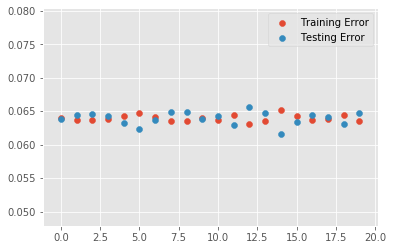

In [9]:
# RMS error with scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
import matplotlib.pyplot as plt
%matplotlib inline

num = 20
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();

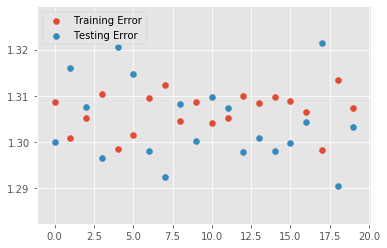

In [10]:
# RMS error with statsmodels 
import statsmodels.tools
num = 20
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    X_opt = X_train[:, [i for i in range(np.size(X_train,1))]]
    regressor_OLS = sm.OLS(y_train, X_opt).fit()
    
    linreg.fit(X_train, y_train)
    y_hat_train = regressor_OLS.predict(X_train)
    y_hat_test = regressor_OLS.predict(X_test)
    train_err.append(statsmodels.tools.eval_measures.rmse(y_train, y_hat_train, axis=0))
    test_err.append(statsmodels.tools.eval_measures.rmse(y_test, y_hat_test, axis=0))
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();

### K-fold cross validation 

In [11]:
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
print("cv_5 MSE = ", cv_5_results)
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
print("cv_10 MSE = ", cv_10_results)
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))
print("cv_20 MSE = ", cv_20_results)
cv_40_results = np.mean(cross_val_score(linreg, X, y, cv=40, scoring='neg_mean_squared_error'))
print("cv_40 MSE = ", cv_40_results)

cv_5 MSE =  -0.064615106776205
cv_10 MSE =  -0.06452136165898742
cv_20 MSE =  -0.06423453204433402
cv_40 MSE =  -0.06414636300113091


## Visualizing relationship of the "price" with final features 

In [18]:
['price']+result

['price',
 'sqft_living15',
 'sqft_living',
 'grade',
 'lat',
 'yr_built',
 'bathrooms',
 'condition',
 'floors',
 'waterfront_1',
 'zipcode',
 'long',
 'sqft_lot',
 'season_spring',
 'bedrooms',
 'sqft_basement']

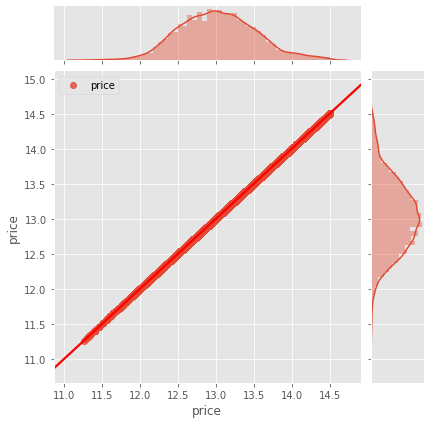

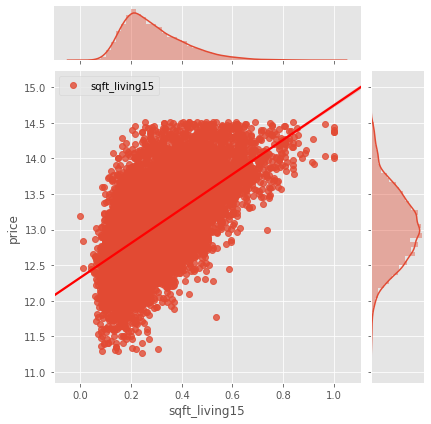

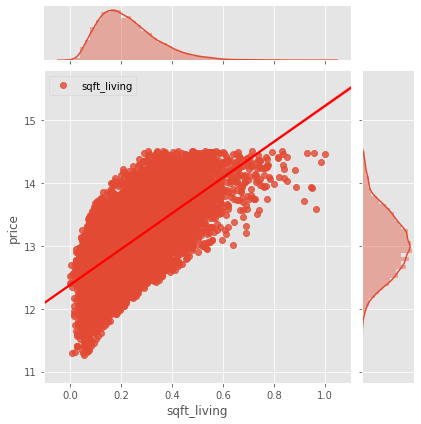

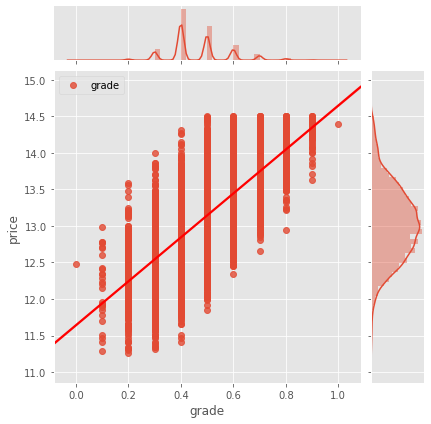

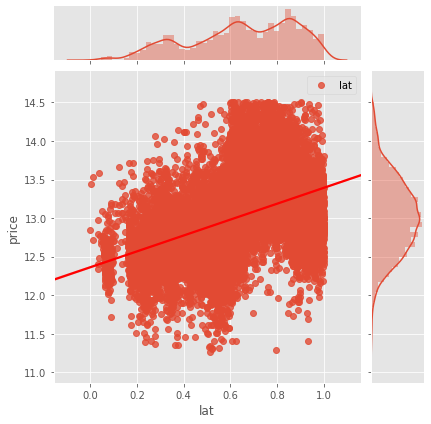

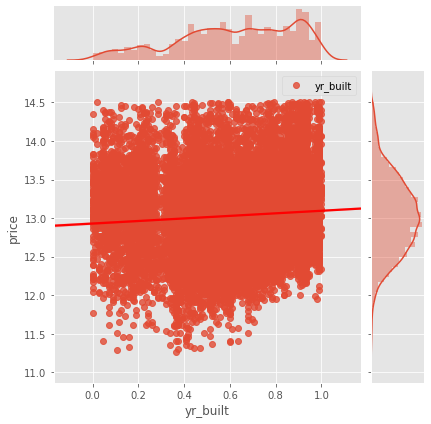

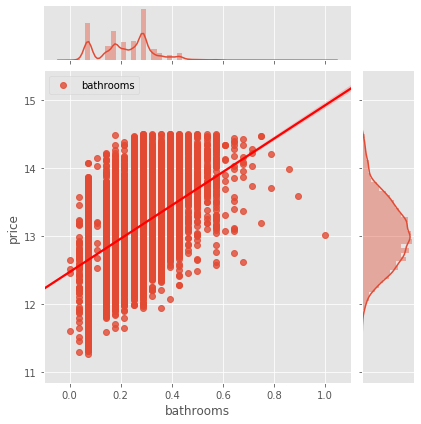

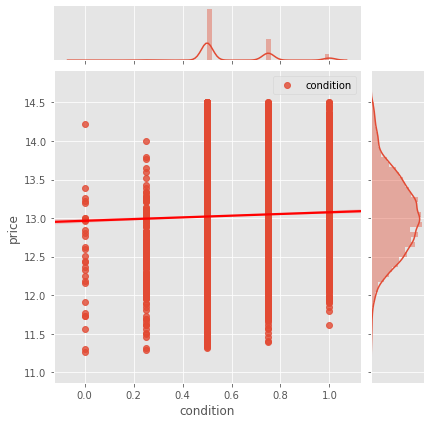

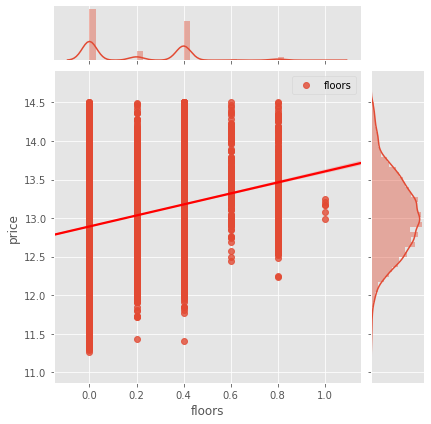

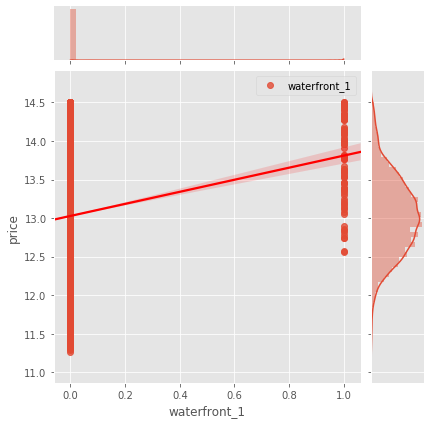

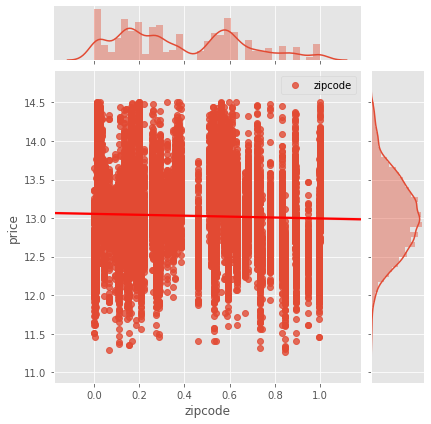

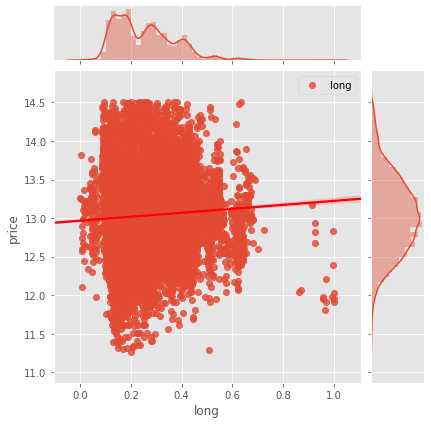

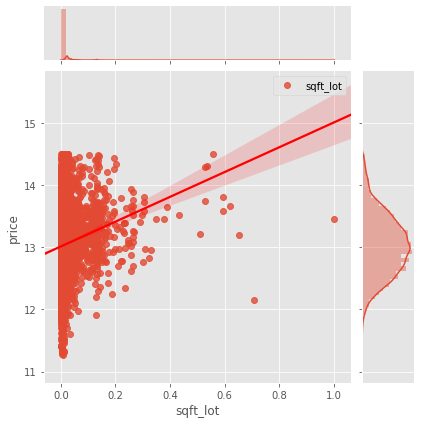

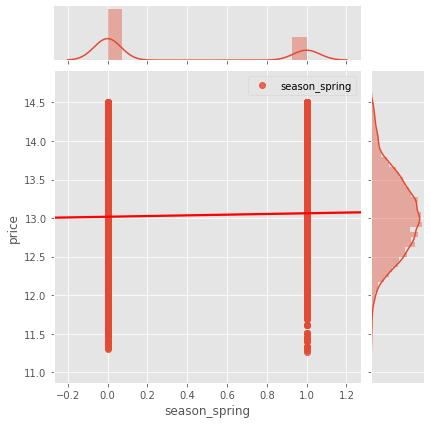

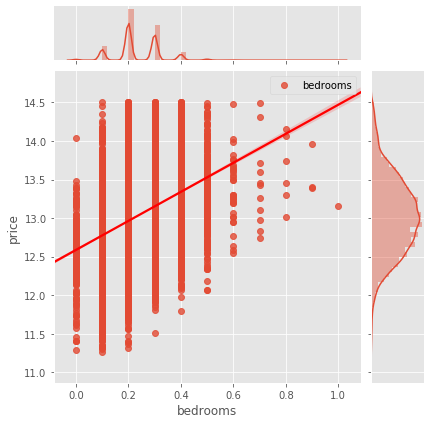

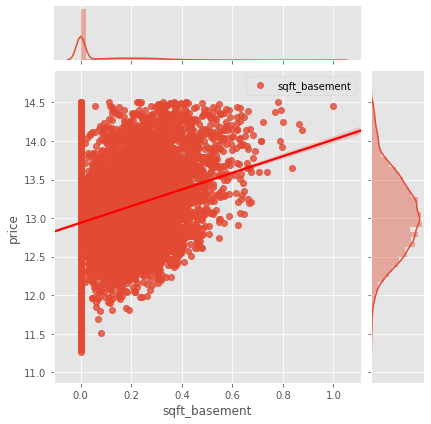

In [19]:
tmp_kc = kc_final[['price']+result]

headers=tmp_kc.columns

#once again just iterating through our list of columns so that we get each separate plot
for column in headers:
    sns.jointplot(x=column, y="price", #creating our joint plot as well as setting our columns to be predictors and price to be our target
                  data=tmp_kc, #we want the jointplots to be created using our df_price_log dataset
                  kind='reg', 
                  label=column, 
                  joint_kws={'line_kws':{'color':'red'}}) #stylistic choices

    plt.legend() #including a legend for our plots
    plt.show()

## Conclusion

## Acknoledgement